# Learn OpenAI Whisper - Chapter 5
## Notebook 2: Transcribing and translating with Whisper

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1iAkLCMvhRcU50HM0AzY3pjgtE2RS65tR)

This notebook provides a comprehensive guide for using OpenAI's Whisper model for multilingual automatic speech recognition (ASR) and translation. It's tailored for anyone eager to dive into the capabilities of Whisper, particularly in handling diverse languages. Here's a breakdown of its purpose, the steps involved, and the benefits it offers:

### Purpose:
- **Demonstrate Whisper's installation and usage:** Shows how to set up Whisper in a Python environment, including the installation of necessary libraries.
- **Multilingual ASR and translation:** Illustrates how to perform speech recognition and translation across various languages using Whisper.
- **Dataset handling:** Utilizes the Fleurs dataset for demonstrating Whisper's capabilities on multilingual audio data.
- **Interactive demonstration:** Incorporates an interactive Gradio interface, allowing users to experiment with Whisper's transcription and translation features on selected audio samples.

### High-Level Steps:
1. **Installation:** Installs Whisper and other required Python packages like `librosa`, `gradio`, and `kaleido` for audio processing, visualization, and creating interactive web apps.
2. **Environment setup:** Prepares the Python environment, including handling potential compatibility issues (e.g., with TensorFlow in Colab) and setting up the device for computation.
3. **Dataset loading:** Provides a widget for selecting a language from the Fleurs dataset, demonstrating how to dynamically work with multilingual data.
4. **Data Preprocessing:** Implements a custom `Fleurs` class to download, extract, and preprocess audio files from the selected language dataset.
5. **Whisper model loading and inference:** Loads the Whisper model, runs it on the dataset to perform transcription and translation, and collects the results.
6. **Interactive exploration with Gradio:** Sets up a Gradio interface to allow users to interactively select audio samples, adjust inference parameters, and view the ASR and translation results alongside the original audio.

### Benefits:
- **Practical learning:** By following this code, learners can gain hands-on experience with one of the most advanced ASR and translation models available, understanding both its strengths and limitations across different languages.
- **Interactive experience:** The inclusion of Gradio for interactive exploration makes it easy for readers to experiment with various settings and hear the outcomes directly, enhancing the learning experience.
- **Comprehensive approach:** This example covers the entire workflow from data preparation to model inference and result visualization, providing a solid foundation for building similar applications.
- **Multilingual support:** Demonstrates Whisper's multilingual capabilities, offering insights into working with non-English audio data, which is invaluable for global applications and research.

This guide is an excellent starting point for anyone interested in exploring the intersection of speech processing and machine learning, offering practical insights into using OpenAI's Whisper model effectively.

# Installing Whisper

The commands below will install the Python packages needed to use Whisper models and evaluate the transcription results.

In [ ]:
%%capture
!pip install -q cohere openai tiktoken
!pip install -q librosa
!pip install git+https://github.com/openai/whisper.git
!pip install gradio kaleido

In [ ]:
import io
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import urllib
import tarfile
import whisper
import torchaudio

from scipy.io import wavfile
from tqdm.notebook import tqdm

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


# Loading the Fleurs dataset

Select the language of the FLEURS dataset to download. Please note that the transcription and translation performance varies widely depending on the language.

[**FLEURS**](https://arxiv.org/abs/2205.12446) stands for **Few-shot Learning Evaluation of Universal Representations of Speech**. It's a benchmark designed to evaluate the performance of universal speech representations in a **few-shot learning** scenario.

Here are the key details about FLEURS:

- **Dataset**: FLEURS is an **n-way parallel speech dataset** that spans **102 languages**. It is built on top of the machine translation benchmark called **FLoRes-101**.
- **Speech Supervision**: Each language in FLEURS has approximately **12 hours of speech supervision**.
- **Tasks**: FLEURS can be used for various speech-related tasks, including:
    - **Automatic Speech Recognition (ASR)**: Converting spoken language into text.
    - **Speech Language Identification (Speech LangID)**: Identifying the language spoken in an audio clip.
    - **Translation and Retrieval**: Leveraging universal speech representations for translation and retrieval tasks.

The goal of FLEURS is to enable speech technology in more languages and catalyze research in **low-resource speech understanding**

In [ ]:
import ipywidgets as widgets

languages = {"af_za": "Afrikaans", "am_et": "Amharic", "ar_eg": "Arabic", "as_in": "Assamese", "az_az": "Azerbaijani",
             "be_by": "Belarusian", "bg_bg": "Bulgarian", "bn_in": "Bengali", "bs_ba": "Bosnian", "ca_es": "Catalan", "cmn_hans_cn": "Chinese",
             "cs_cz": "Czech", "cy_gb": "Welsh", "da_dk": "Danish", "de_de": "German", "el_gr": "Greek", "en_us": "English", "es_419": "Spanish",
             "et_ee": "Estonian", "fa_ir": "Persian", "fi_fi": "Finnish", "fil_ph": "Tagalog", "fr_fr": "French", "gl_es": "Galician", "gu_in": "Gujarati",
             "ha_ng": "Hausa", "he_il": "Hebrew", "hi_in": "Hindi", "hr_hr": "Croatian", "hu_hu": "Hungarian", "hy_am": "Armenian", "id_id": "Indonesian", "is_is": "Icelandic",
             "it_it": "Italian", "ja_jp": "Japanese", "jv_id": "Javanese", "ka_ge": "Georgian", "kk_kz": "Kazakh", "km_kh": "Khmer", "kn_in": "Kannada", "ko_kr": "Korean",
             "lb_lu": "Luxembourgish", "ln_cd": "Lingala", "lo_la": "Lao", "lt_lt": "Lithuanian", "lv_lv": "Latvian", "mi_nz": "Maori", "mk_mk": "Macedonian",
             "ml_in": "Malayalam", "mn_mn": "Mongolian", "mr_in": "Marathi", "ms_my": "Malay", "mt_mt": "Maltese", "my_mm": "Myanmar", "nb_no": "Norwegian",
             "ne_np": "Nepali", "nl_nl": "Dutch", "oc_fr": "Occitan", "pa_in": "Punjabi", "pl_pl": "Polish", "ps_af": "Pashto", "pt_br": "Portuguese", "ro_ro": "Romanian",
             "ru_ru": "Russian", "sd_in": "Sindhi", "sk_sk": "Slovak", "sl_si": "Slovenian", "sn_zw": "Shona", "so_so": "Somali", "sr_rs": "Serbian", "sv_se": "Swedish",
             "sw_ke": "Swahili", "ta_in": "Tamil", "te_in": "Telugu", "tg_tj": "Tajik", "th_th": "Thai", "tr_tr": "Turkish", "uk_ua": "Ukrainian", "ur_pk": "Urdu", "uz_uz": "Uzbek",
             "vi_vn": "Vietnamese", "yo_ng": "Yoruba"}
selection = widgets.Dropdown(
    options=[("Select language", None), ("----------", None)] + sorted([(f"{v} ({k})", k) for k, v in languages.items()]),
    value="ko_kr",
    description='Language:',
    disabled=False,
)

selection

Dropdown(description='Language:', index=39, options=(('Select language', None), ('----------', None), ('Afrika…

In [ ]:
lang = selection.value
language = languages[lang]

assert lang is not None, "Please select a language"
print(f"Selected language: {language} ({lang})")

Selected language: German (de_de)


In [ ]:
def download(url: str, target_path: str):
    with urllib.request.urlopen(url) as source, open(target_path, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))


class Fleurs(torch.utils.data.Dataset):
    """
    A simple class to wrap Fleurs and subsample a portion of the dataset as needed.
    """
    def __init__(self, lang, split="test", subsample_rate=1, device=DEVICE):
        url = f"https://storage.googleapis.com/xtreme_translations/FLEURS102/{lang}.tar.gz"
        tar_path = os.path.expanduser(f"~/.cache/fleurs/{lang}.tgz")
        os.makedirs(os.path.dirname(tar_path), exist_ok=True)

        if not os.path.exists(tar_path):
            download(url, tar_path)

        all_audio = {}
        with tarfile.open(tar_path, "r:gz") as tar:
            for member in tar.getmembers():
                name = member.name
                if name.endswith(f"{split}.tsv"):
                    # Ensure you're using the correct method to read the TSV file.
                    # Just make sure it properly handles the TSV data.
                    labels = pd.read_table(tar.extractfile(member), names=("id", "file_name", "raw_transcription", "transcription", "_", "num_samples", "gender"))

                if f"/{split}/" in name and name.endswith(".wav"):
                    audio_bytes = tar.extractfile(member).read()
                    # all_audio[os.path.basename(name)] = wavfile.read(io.BytesIO(audio_bytes))[1]
                    # Use io.BytesIO to create a buffer from the audio bytes
                    # and scipy.io.wavfile.read to read from this buffer.
                    try:
                        rate, data = wavfile.read(io.BytesIO(audio_bytes))
                        all_audio[os.path.basename(name)] = data
                    except ValueError as e:
                        print(f"Error reading {name}: {e}")

        self.labels = labels.to_dict("records")[::subsample_rate]
        self.all_audio = all_audio
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        record = self.labels[item]
        audio = torch.from_numpy(self.all_audio[record["file_name"]].copy())
        text = record["transcription"]

        return (audio, text)

In [ ]:
dataset = Fleurs(lang, subsample_rate=5)  # subsample 5% of the dataset for a quick demo

  0%|                                              | 0.00/2.25G [00:00<?, ?iB/s]

# Running inference on the dataset using a "medium" size Whisper model

The following will take a few minutes to transcribe and translate utterances in the dataset.

In [ ]:
model = whisper.load_model("medium")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|██████████████████████████████████████| 1.42G/1.42G [00:12<00:00, 122MiB/s]


Model is multilingual and has 762,321,920 parameters.


In [ ]:
options = dict(language=language, beam_size=5, best_of=5, temperature=0)
transcribe_options = dict(task="transcribe", **options)
translate_options = dict(task="translate", **options)

In [ ]:
references = []
transcriptions = []
translations = []

for audio, text in tqdm(dataset):
    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]

    transcriptions.append(transcription)
    translations.append(translation)
    references.append(text)

  0%|          | 0/173 [00:00<?, ?it/s]

In [ ]:
data = pd.DataFrame(dict(reference=references, transcription=transcriptions, translation=translations))
data.head()

reference  \
0  löwenrudel agieren ähnlich wie wolfs- oder hunderudel tiere die den löwen aber nicht anderen großkatzen im verhalten überraschend ähneln und ebenso tödlich gegenüber ihrer beute sind   
1                                                                                     ziegen wurden anscheinend bereits vor ungefähr 10.000 jahren im zāgros-gebirge im iran domestiziert   
2                                                es gibt familienstrände die manchmal überlaufen sind mit einer schönen einkaufspromenade entlang der küste das schwimmen ist hier sicher   
3                                                                                sein ruhm als epizentrum des luxus begann ungefähr um 400 n chr. und dauerte bis ungefähr 1100 n chr. an   
4                                    da kometen vor langer zeit mit der erde zusammenprallten versprechen sich die wissenschaftler einblicke wie planeten insbesondere die erde entstehen   

                                                                                                                                                                                 transcription  \
0   Löwenrudel agieren ähnlich wie Wolfs- oder Hunderudel, Tiere, die den Löwen, aber nicht anderen Großkatzen im Verhalten überraschend ähneln und ebenso tödlich gegenüber ihrer Beute sind.   
1                                                                                          Ziegen wurden anscheinend bereits vor ungefähr 10.000 Jahren im Zagrosgebirge im Iran domestiziert.   
2                                                  Es gibt Familienstrände, die manchmal überlaufen sind mit einer schönen Einkaufspromenade entlang der Küste. Das Schwimmen ist hier sicher.   
3                                                                      Sein Ruhm als Epizentrum des Luxus begann ungefähr um 400 nach Christus und dauerte bis ungefähr 1100 nach Christus an.   
4                                      Da Kometen vor langer Zeit mit der Erde zusammenprallten, versprechen sich die Wissenschaftler Einblicke, wie Planeten insbesondere die Erde entstehen.   

                                                                                                                                                       translation  
0   Lion rodents act similar to wolf or dog rodents, animals that resemble the lion but not other big cats in their behavior and are equally deadly to their prey.  
1                                                       It seems that goats have already been domesticated in the Zagros mountains in Iran about 10,000 years ago.  
2                                   There are family beaches that are sometimes overflowing with a nice shopping promenade along the coast. Swimming is safe here.  
3                                                                          His fame as the epicenter of luxury began around 400 AD and lasted until about 1100 AD.  
4                          Since comets collided with the earth a long time ago, scientists promise that insights like planets, especially the earth, will emerge.

In [ ]:
indexa = 0
audio, text = dataset[indexa]
print(f"Reference: {text}")
print(f"Transcription: {data.iloc[indexa].transcription}")
print(f"Translation: {data.iloc[indexa].translation}")

from IPython.display import Audio
Audio(data=audio, rate=16000)

Reference: löwenrudel agieren ähnlich wie wolfs- oder hunderudel tiere die den löwen aber nicht anderen großkatzen im verhalten überraschend ähneln und ebenso tödlich gegenüber ihrer beute sind
Transcription:  Löwenrudel agieren ähnlich wie Wolfs- oder Hunderudel, Tiere, die den Löwen, aber nicht anderen Großkatzen im Verhalten überraschend ähneln und ebenso tödlich gegenüber ihrer Beute sind.
Translation:  Lion rodents act similar to wolf or dog rodents, animals that resemble the lion but not other big cats in their behavior and are equally deadly to their prey.


In [ ]:
import torchaudio
import tempfile
import gradio as gr

def process_audio(index, beam_size, best_of, temperature):
    audio, text = dataset[index]

    # Save the tensor to an audio file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as tmpfile:
        temp_filepath = tmpfile.name
        torchaudio.save(temp_filepath, audio.unsqueeze(0), 16000)  # Adjust the sample rate as needed

    # Use the user-provided beam_size and best_of for transcription and translation
    options = dict(language=language, beam_size=beam_size, best_of=best_of, temperature=temperature)
    transcribe_options = dict(task="transcribe", **options)
    translate_options = dict(task="translate", **options)

    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]

    return text, transcription, translation, temp_filepath

def gradio_interface(index, beam_size, best_of, temperature):
    reference, transcription, translation, temp_filepath = process_audio(index, beam_size, best_of, temperature)

    # Display the results using the file path
    return reference, transcription, translation, gr.Audio(temp_filepath)

iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Slider(minimum=0, maximum=len(dataset)-1, step=1, label="Select Audio Sample"),
        gr.Slider(minimum=0, maximum=5, step=1, label="Beam Size", value=5),
        gr.Slider(minimum=0, maximum=5, step=1, label="Best Of", value=5),
        gr.Slider(minimum=0, maximum=1, step=.1, label="Temperature", value=0.2)
    ],
    outputs=[
        gr.Textbox(label="Reference Text"),
        gr.Textbox(label="Transcription"),
        gr.Textbox(label="Translation"),
        gr.Audio(label="Audio")
    ],
    title="Learn OpenAI Whisper: Audio Processing",
    description="Slide to select an audio sample and adjust 'beam size', 'best of', and 'temperature' to view its reference text, transcription, and translation along with an audio player."
)

# Launch the app
iface.launch(debug=False)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://76e5fc443a749aa019.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Word-level timestamps using attention weights

This section demonstrates an advanced technique for extracting word-level timestamps from audio transcriptions using OpenAI's Whisper model, leveraging cross-attention weights. It's designed for readers who are interested in deep learning, speech processing, and specifically those working with the Whisper model for speech-to-text tasks.

### Requirements and dependencies:
- **Python Libraries:** The script requires `dtw-python` for dynamic time warping, `matplotlib` for visualization, and `pandas` for data handling, among others.
- **Whisper Model:** Understanding the inner workings of OpenAI's Whisper model is crucial, as the script directly interacts with its layers and functions.

### Purpose:
- **Word-Level Timestamps Extraction:** The primary goal is to align the words in the transcript with specific times in the audio recording. This is particularly useful for applications like subtitle generation, detailed audio analysis, and improving accessibility features in media.
- **Granular Analysis with Attention Weights:** It utilizes the model's cross-attention weights to achieve a finer granularity in alignment, beyond what is typically available through simpler transcription methods.

### How it works:
1. **Dynamic time warping (DTW):** The code uses DTW, a well-known algorithm in speech recognition, to find the optimal alignment between two sequences (here, the audio and the text). DTW is particularly effective in compensating for speed variations in speech.
2. **Attention weights:** By tapping into the cross-attention layers of the Whisper model, the script calculates how each word in the transcript correlates with segments of the audio, providing a basis for timestamping.
3. **Data preparation and processing:** It includes preprocessing steps like median filtering to smooth the attention weights and normalization to ensure meaningful comparisons.
4. **Visualization and output:** The script visualizes the alignment and provides detailed timestamps for each word, making it easy to see how the text matches the audio. It also demonstrates how to handle languages with different characteristics (e.g., space usage in text) for accurate word splitting.

### Applicability:
- **Educational content:** Readers of "Learn OpenAI Whisper" can use this as a practical example of applying Whisper for detailed speech analysis, going beyond basic transcription to understand the dynamics of attention mechanisms in audio processing.
- **Research and development:** This approach can inspire researchers and developers to explore advanced speech processing techniques, such as improving automatic subtitle generation, enhancing language learning tools, or creating more interactive and accessible media content.
- **Language-specific handling:** The code is designed to accommodate languages with different characteristics, providing insights into handling multilingual audio data effectively.

### Installing necessary libraries
First, we install `dtw-python` to use Dynamic Time Warping (DTW) for aligning audio and text sequences based on their temporal similarities.


In [ ]:
! pip install dtw-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.7/744.7 kB 5.1 MB/s eta 0:00:00


### Importing libraries and setting up environment
We import necessary Python libraries for data manipulation, visualization, and handling audio files. This includes `matplotlib` for plotting, `dtw` for dynamic time warping, and Whisper's tokenizer for processing text.


In [ ]:
import string
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

from IPython.display import display, HTML
from whisper.tokenizer import get_tokenizer
from dtw import dtw
from scipy.ndimage import median_filter

%matplotlib inline
%config InlineBackend.figure_format = "retina"

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Constants and configuration
Here, we define constants related to audio processing in Whisper and set up the matplotlib environment for better visual output. This includes setting the audio sample rate and configuring the inline backend for high-resolution figures.


In [ ]:
AUDIO_SAMPLES_PER_TOKEN = whisper.audio.HOP_LENGTH * 2
AUDIO_TIME_PER_TOKEN = AUDIO_SAMPLES_PER_TOKEN / whisper.audio.SAMPLE_RATE

medfilt_width = 7
qk_scale = 1.0

tokenizer = get_tokenizer(model.is_multilingual, language=languages[lang])

### Handling fonts for visualization
This section deals with downloading and setting up fonts compatible with various languages for visualization purposes. It ensures that the plotted figures can correctly display characters from different language scripts.

In [ ]:
# This part downloads a repackaged version of the Noto Sans font (either CJK or non-CJK)
# to render various languages in Matplotlib figures.

if languages[lang] in {"Chinese", "Japanese", "Korean"}:
    font = "GoNotoCJKCore.ttf"
else:
    font = "GoNotoCurrent.ttf"

font_release = "https://github.com/satbyy/go-noto-universal/releases/download/v5.2"
if not os.path.exists(font):
    download(f"{font_release}/{font}", font)

prop = fm.FontProperties(fname=font)
props = {'fontproperties': prop}

  0%|                                              | 0.00/14.2M [00:00<?, ?iB/s]

### Preparing for text processing
We initialize the tokenizer from Whisper, adjusting for multilingual support and specific language requirements. This is crucial for accurately converting text sequences into tokens that Whisper can process.
#### Utility functions for token splitting
Two utility functions are defined to split tokens based on unicode characters and spaces. These functions help in identifying word boundaries in the transcribed text, which is essential for generating word-level timestamps later.

In [ ]:
def split_tokens_on_unicode(tokens: torch.Tensor):
    words = []
    word_tokens = []
    current_tokens = []

    for token in tokens.tolist():
        current_tokens.append(token)
        decoded = tokenizer.decode_with_timestamps(current_tokens)
        if "\ufffd" not in decoded:
            words.append(decoded)
            word_tokens.append(current_tokens)
            current_tokens = []

    return words, word_tokens

In [ ]:
def split_tokens_on_spaces(tokens: torch.Tensor):
    subwords, subword_tokens_list = split_tokens_on_unicode(tokens)
    words = []
    word_tokens = []

    for subword, subword_tokens in zip(subwords, subword_tokens_list):
        special = subword_tokens[0] >= tokenizer.eot
        with_space = subword.startswith(" ")
        punctuation = subword.strip() in string.punctuation
        if special or with_space or punctuation:
            words.append(subword)
            word_tokens.append(subword_tokens)
        else:
            words[-1] = words[-1] + subword
            word_tokens[-1].extend(subword_tokens)

    return words, word_tokens

In [ ]:
if languages[lang] in {"Chinese", "Japanese", "Thai", "Lao", "Myanmar"}:
    # These languages don't typically use spaces, so it is difficult to split words
    # without morpheme analysis. Here, we instead split words at any
    # position where the tokens are decoded as valid unicode points
    split_tokens = split_tokens_on_unicode
else:
    split_tokens = split_tokens_on_spaces

### Setting up hooks for attention weights
Hooks are installed on the cross-attention layers of the Whisper model to capture the attention weights during inference. These weights are crucial for understanding how the model aligns audio segments with specific words.


In [ ]:
# install hooks on the cross attention layers to retrieve the attention weights
QKs = [None] * model.dims.n_text_layer

for i, block in enumerate(model.decoder.blocks):
    block.cross_attn.register_forward_hook(
        lambda _, ins, outs, index=i: QKs.__setitem__(index, outs[-1])
    )

### Processing audio and generating timestamps

For a subset of the dataset, this loop processes each audio file, generates its mel spectrogram, and performs inference using the Whisper model. It then uses the captured attention weights and DTW to align words in the transcription with their corresponding audio segments, creating word-level timestamps.


 Löwenrudel agieren ähnlich wie Wolfs- oder Hunderudel, Tiere, die den Löwen, aber nicht anderen Großkatzen im Verhalten überraschend ähneln und ebenso tödlich gegenüber ihrer Beute sind.


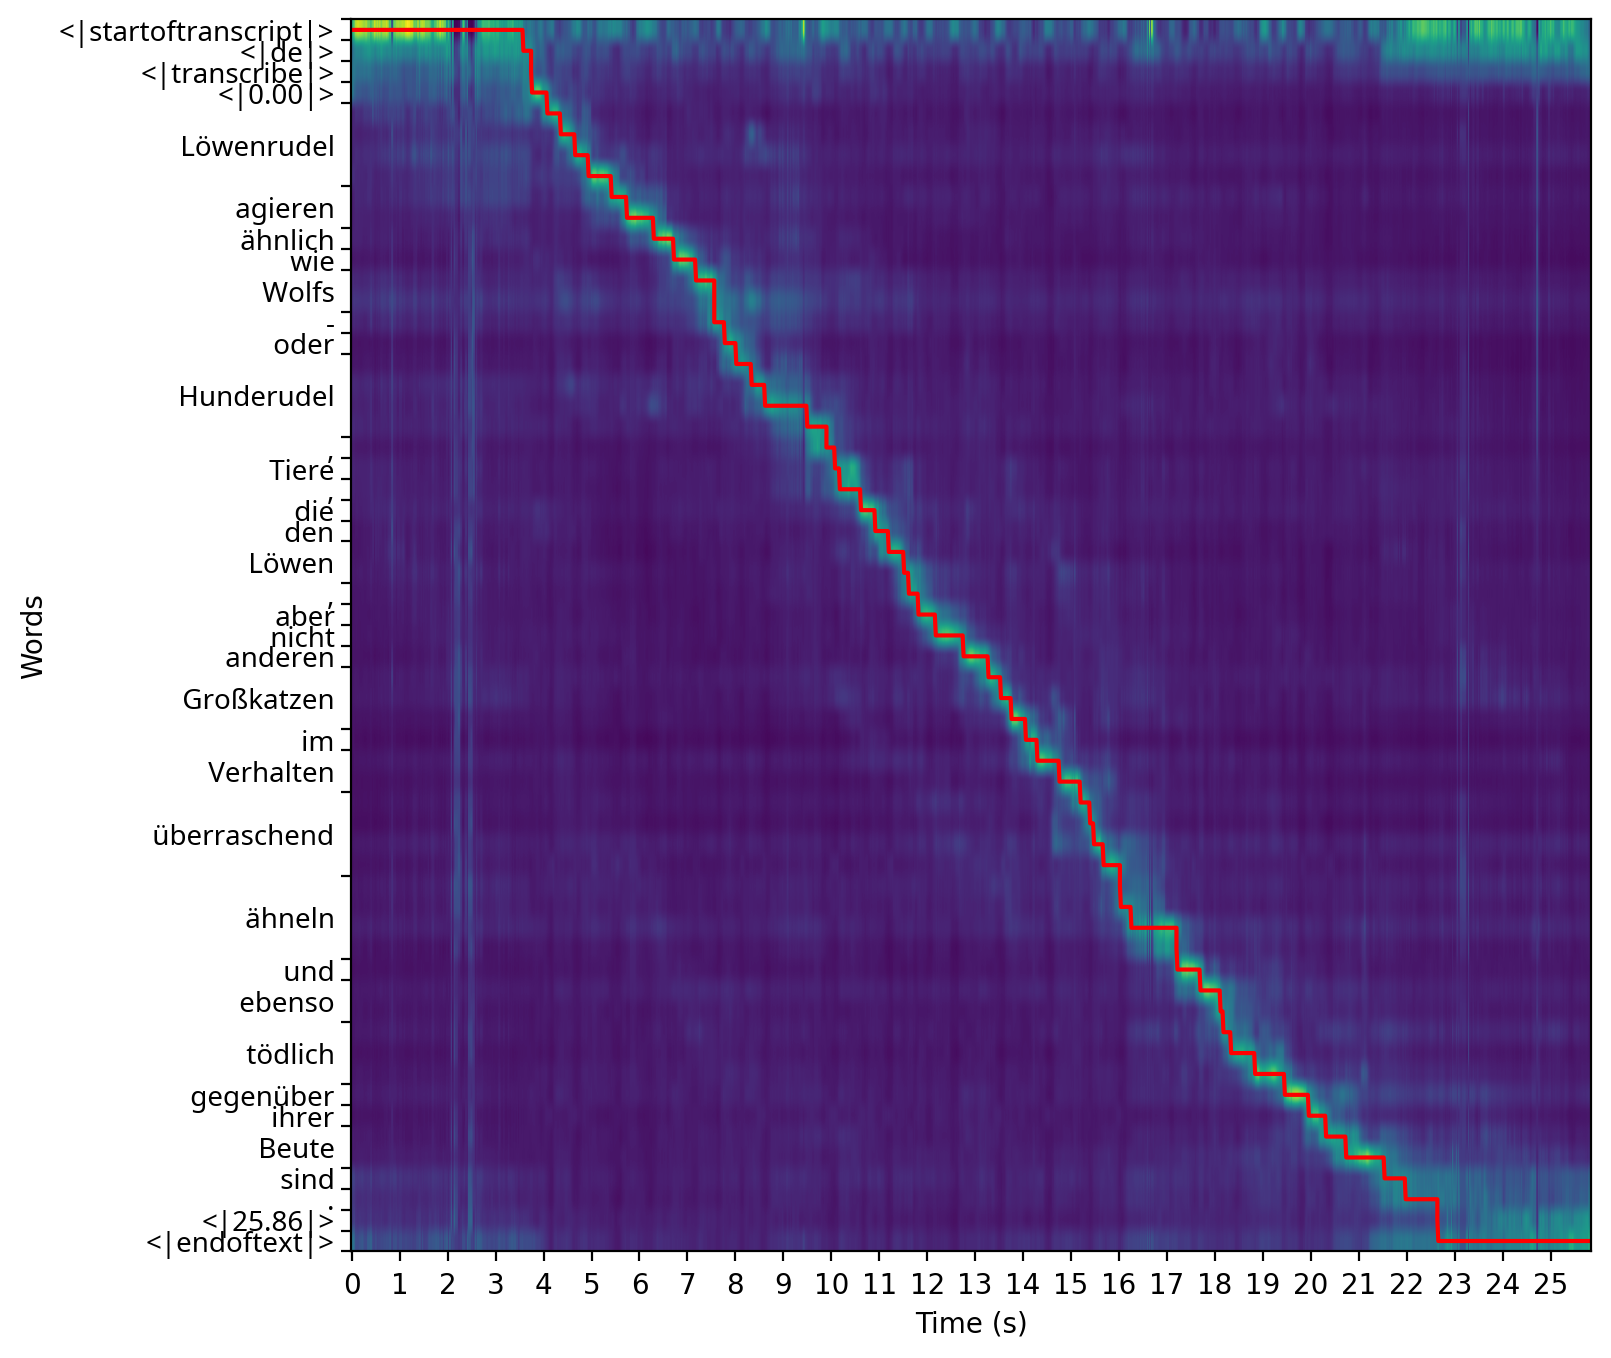

word  begin    end
0      Löwenrudel   4.08   5.42
1         agieren   5.42   6.30
2         ähnlich   6.30   6.72
3             wie   6.72   7.18
4           Wolfs   7.18   7.56
5               -   7.56   7.78
6            oder   7.78   8.02
7      Hunderudel   8.02   9.90
8           Tiere  10.08  10.18
9             die  10.62  10.92
10            den  10.92  11.20
11          Löwen  11.20  11.62
12           aber  11.82  12.18
13          nicht  12.18  12.76
14        anderen  12.76  13.28
15     Großkatzen  13.28  14.06
16             im  14.06  14.30
17      Verhalten  14.30  15.20
18   überraschend  15.20  16.02
19         ähneln  16.02  17.22
20            und  17.22  17.70
21         ebenso  17.70  18.18
22        tödlich  18.18  19.46
23      gegenüber  19.46  19.96
24          ihrer  19.96  20.32
25          Beute  20.32  21.54
26           sind  21.54  21.98

 Ziegen wurden anscheinend bereits vor ungefähr 10.000 Jahren im Zagrosgebirge im Iran domestiziert.


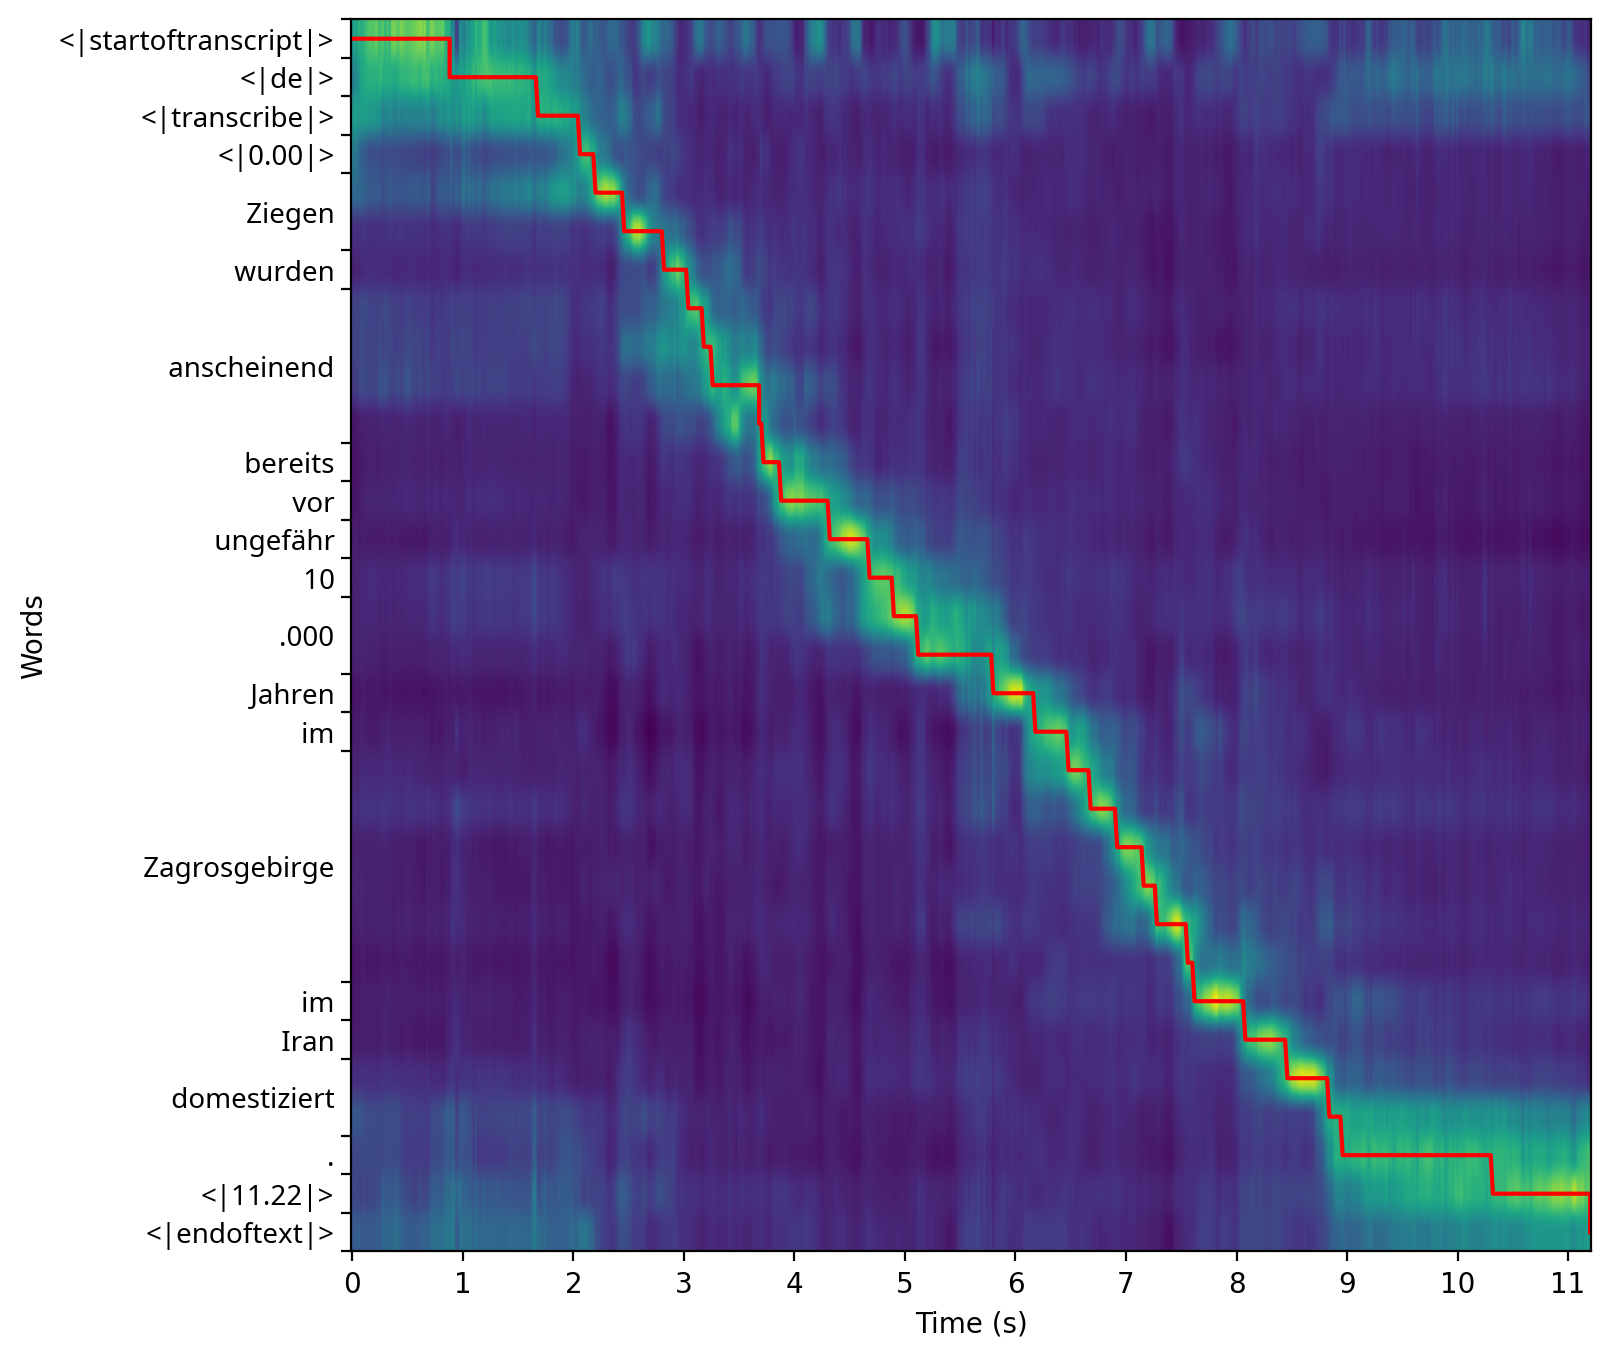

word  begin   end
0           Ziegen   2.20  2.82
1           wurden   2.82  3.04
2      anscheinend   3.04  3.72
3          bereits   3.72  3.88
4              vor   3.88  4.32
5         ungefähr   4.32  4.68
6               10   4.68  4.90
7             .000   4.90  5.80
8           Jahren   5.80  6.18
9               im   6.18  6.48
10   Zagrosgebirge   6.48  7.62
11              im   7.62  8.08
12            Iran   8.08  8.46
13    domestiziert   8.46  8.96

 Es gibt Familienstrände, die manchmal überlaufen sind mit einer schönen Einkaufspromenade entlang der Küste. Das Schwimmen ist hier sicher.


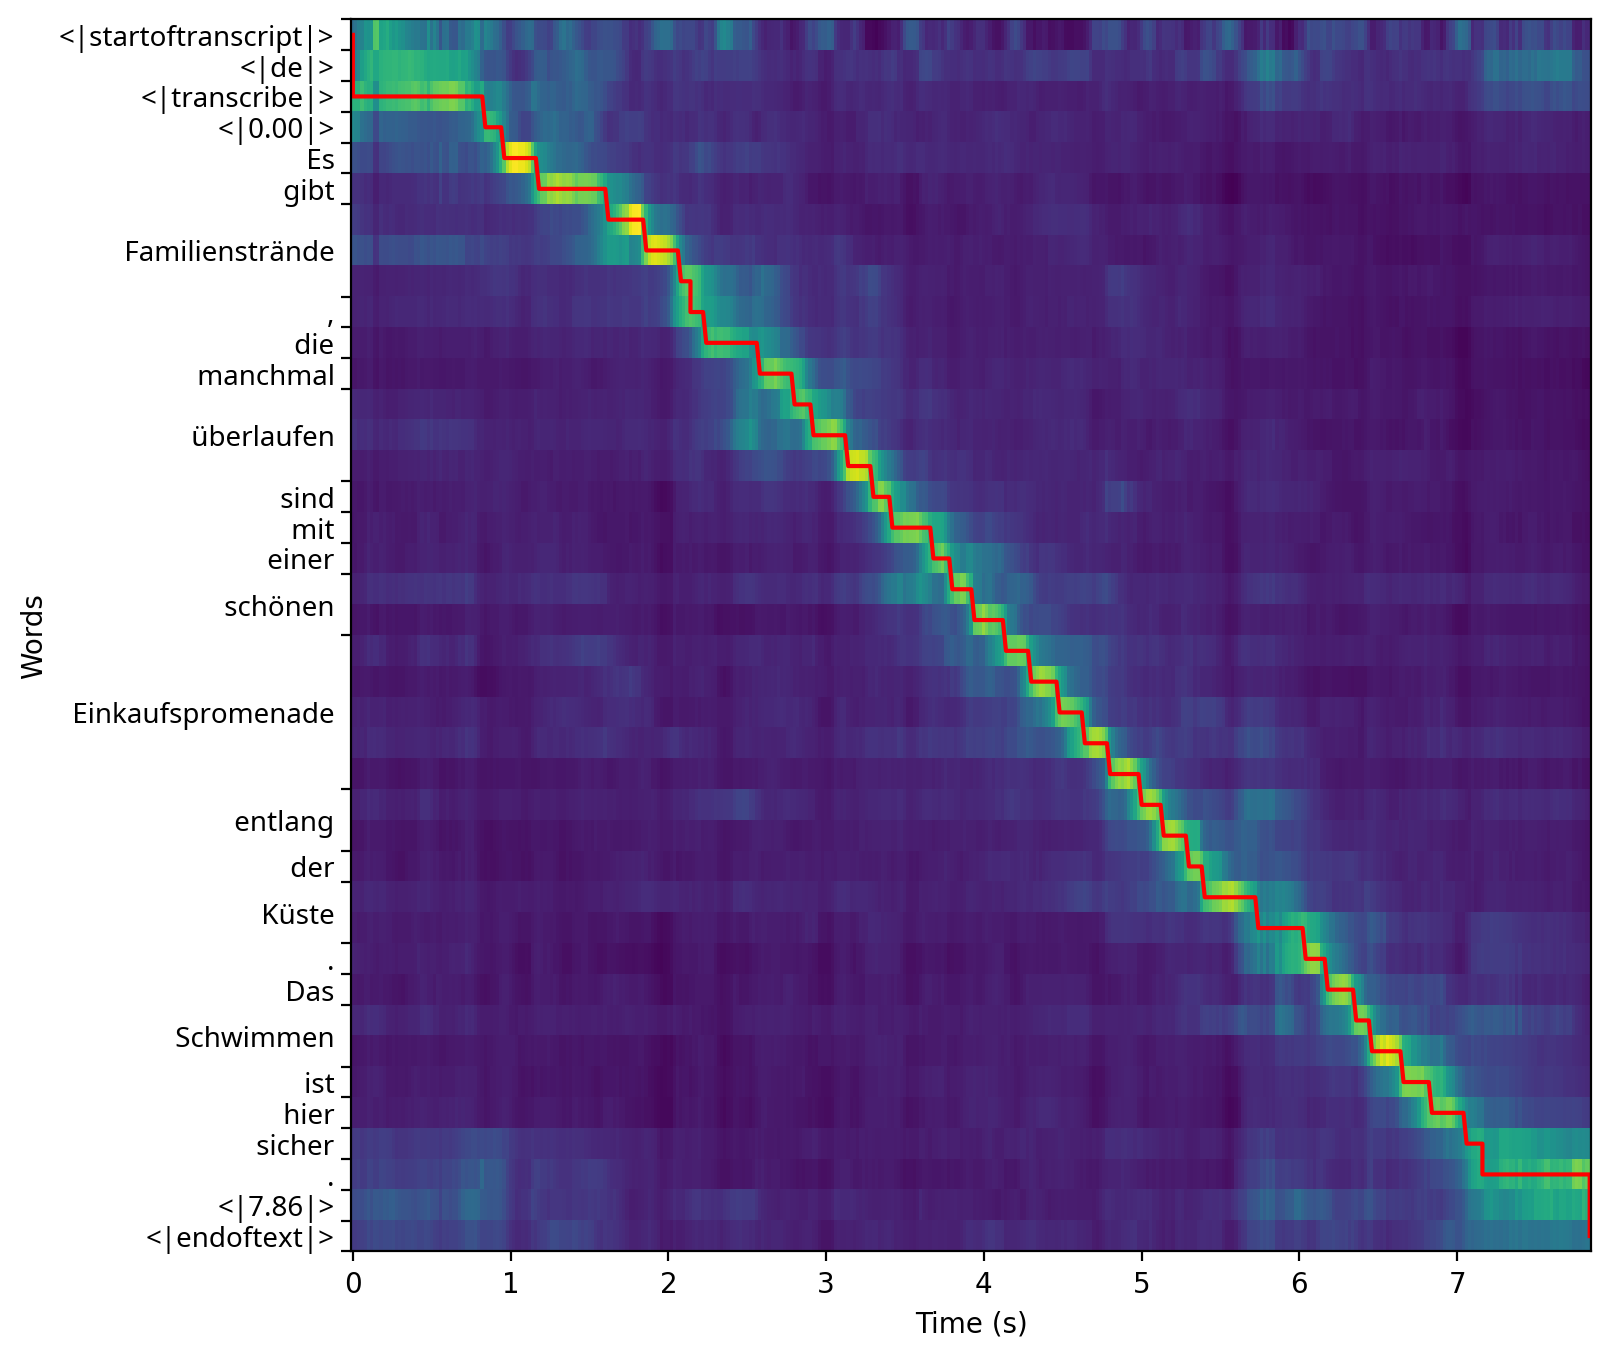

word  begin   end
0                   Es   0.96  1.18
1                 gibt   1.18  1.62
2      Familienstrände   1.62  2.14
3                  die   2.24  2.58
4             manchmal   2.58  2.80
5           überlaufen   2.80  3.30
6                 sind   3.30  3.42
7                  mit   3.42  3.68
8                einer   3.68  3.80
9              schönen   3.80  4.14
10   Einkaufspromenade   4.14  5.00
11             entlang   5.00  5.30
12                 der   5.30  5.40
13               Küste   5.40  6.04
14                 Das   6.18  6.36
15           Schwimmen   6.36  6.66
16                 ist   6.66  6.84
17                hier   6.84  7.06
18              sicher   7.06  7.16

 Sein Ruhm als Epizentrum des Luxus begann ungefähr um 400 nach Christus und dauerte bis ungefähr 1100 nach Christus an.


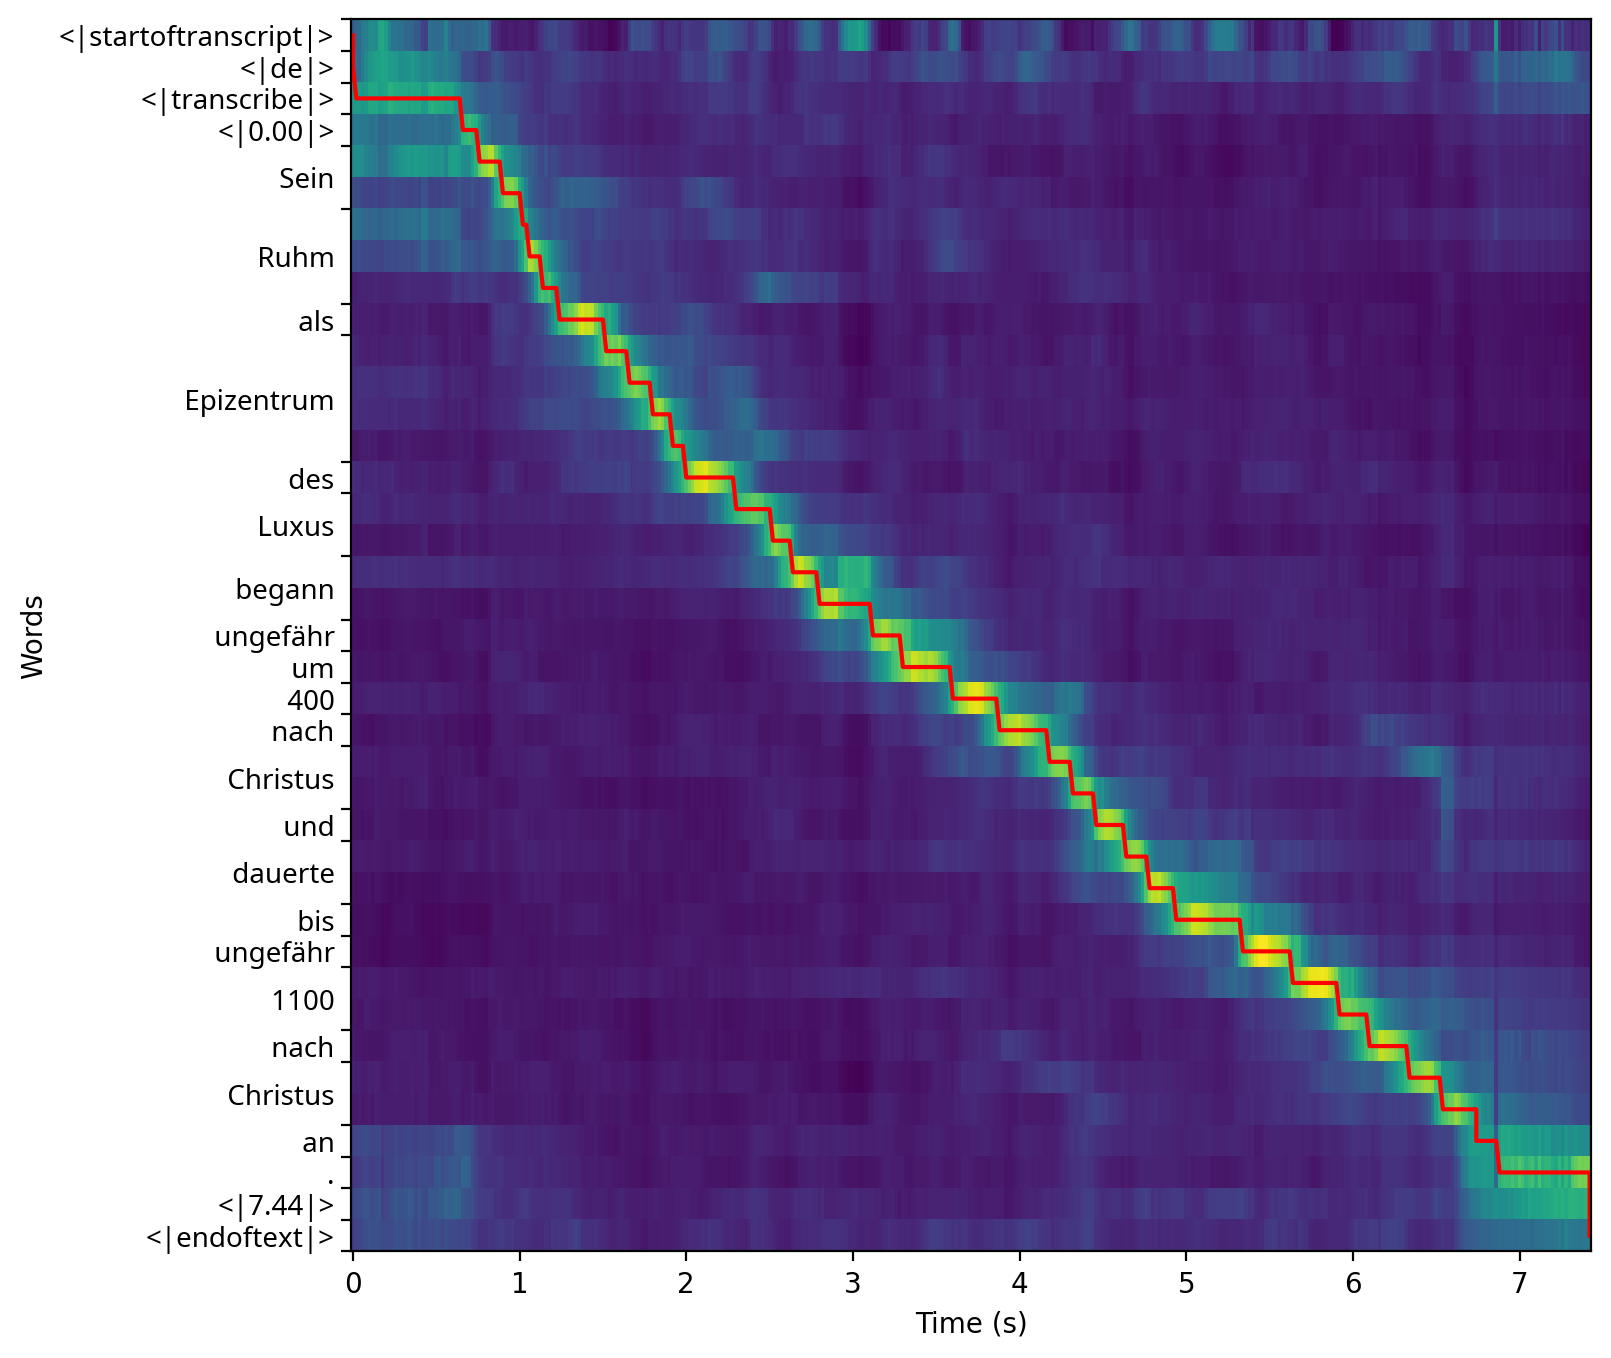

word  begin   end
0          Sein   0.76  1.02
1          Ruhm   1.02  1.24
2           als   1.24  1.52
3    Epizentrum   1.52  2.00
4           des   2.00  2.30
5         Luxus   2.30  2.64
6        begann   2.64  3.12
7      ungefähr   3.12  3.30
8            um   3.30  3.60
9           400   3.60  3.88
10         nach   3.88  4.18
11     Christus   4.18  4.46
12          und   4.46  4.64
13      dauerte   4.64  4.94
14          bis   4.94  5.34
15     ungefähr   5.34  5.64
16         1100   5.64  6.10
17         nach   6.10  6.34
18     Christus   6.34  6.74
19           an   6.74  6.88

 Da Kometen vor langer Zeit mit der Erde zusammenprallten, versprechen sich die Wissenschaftler Einblicke, wie Planeten insbesondere die Erde entstehen.


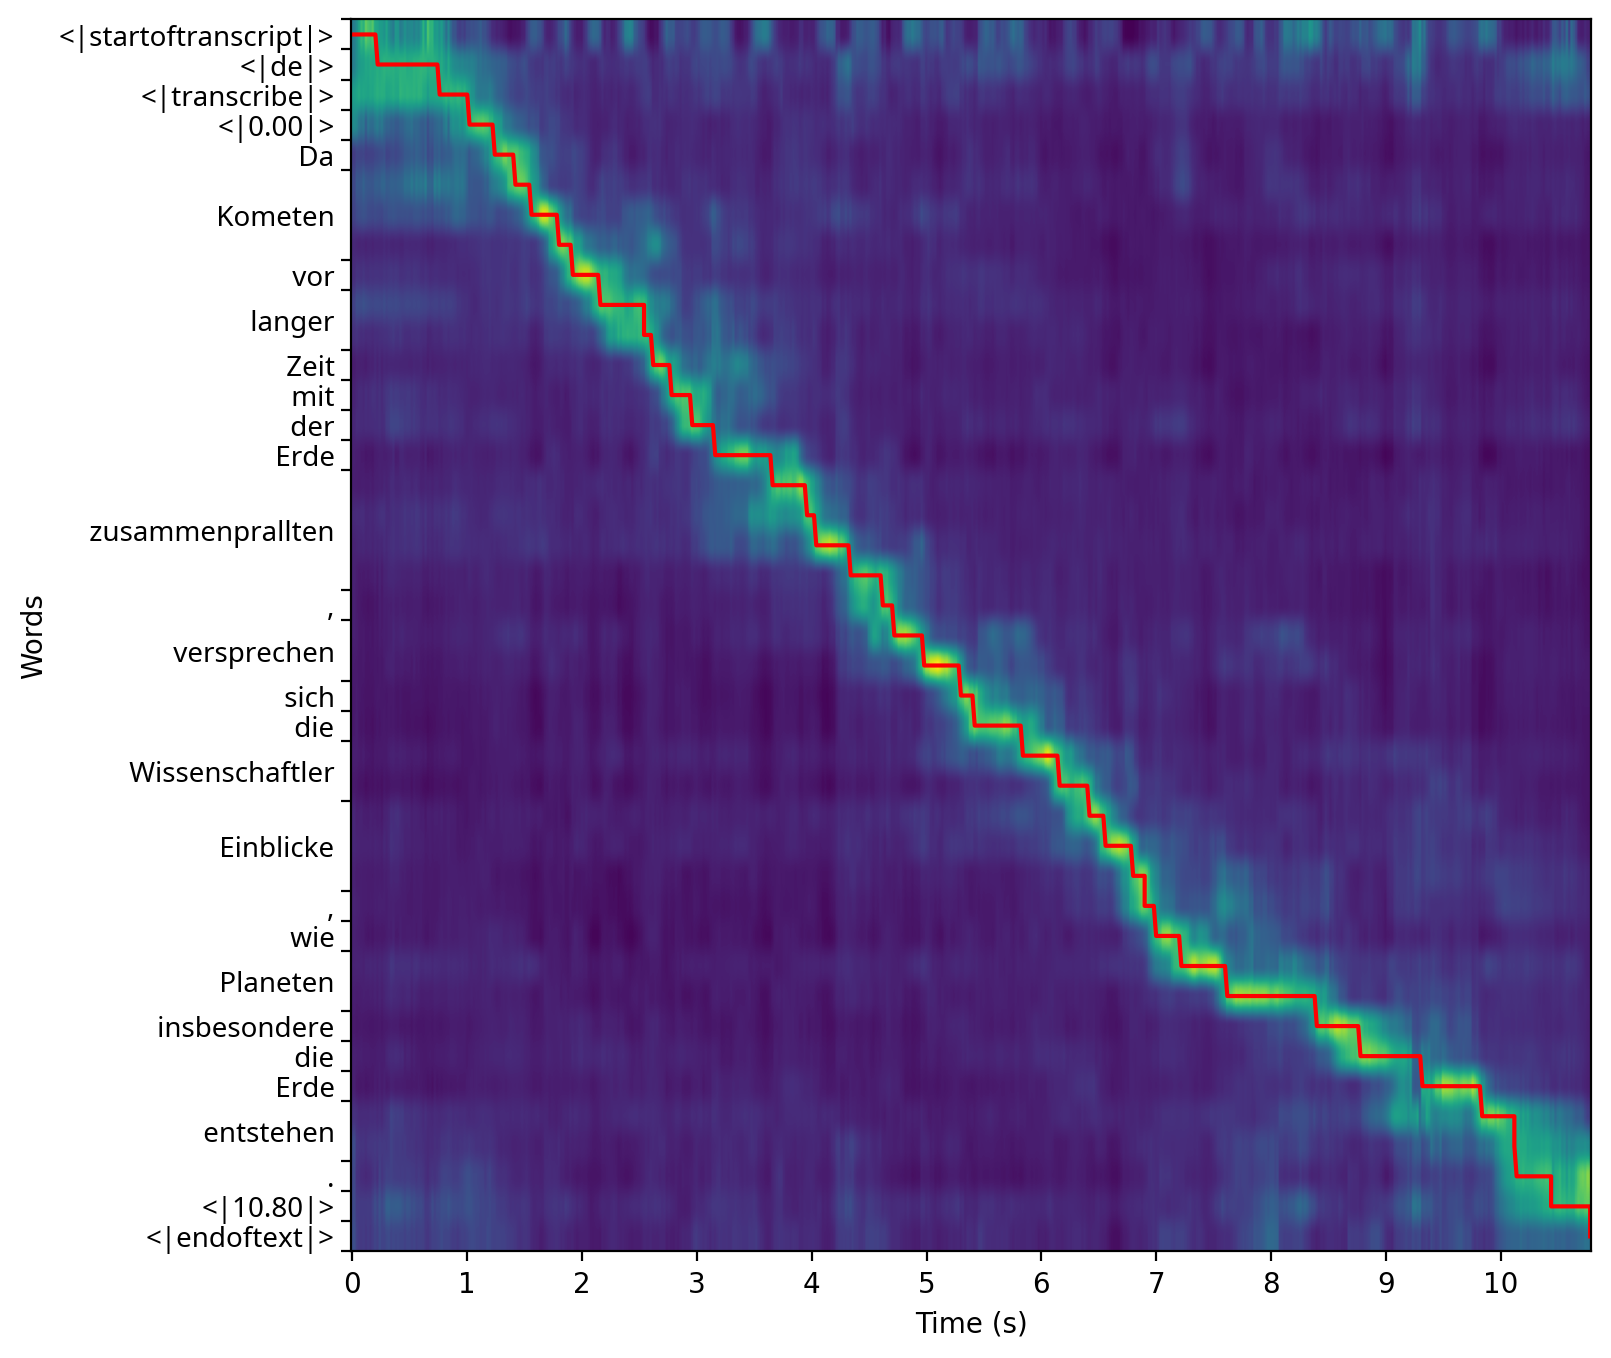

word  begin    end
0                  Da   1.24   1.42
1             Kometen   1.42   1.92
2                 vor   1.92   2.16
3              langer   2.16   2.62
4                Zeit   2.62   2.78
5                 mit   2.78   2.96
6                 der   2.96   3.16
7                Erde   3.16   3.66
8    zusammenprallten   3.66   4.62
9         versprechen   4.72   5.30
10               sich   5.30   5.42
11                die   5.42   5.84
12    Wissenschaftler   5.84   6.42
13          Einblicke   6.42   6.90
14                wie   7.00   7.22
15           Planeten   7.22   8.40
16       insbesondere   8.40   8.78
17                die   8.78   9.32
18               Erde   9.32   9.84
19          entstehen   9.84  10.14

 Die zwei Verbindungen reagieren miteinander und formen Kristalle, die laut Forschern der Hochschule die Nierentätigkeit behindern können.


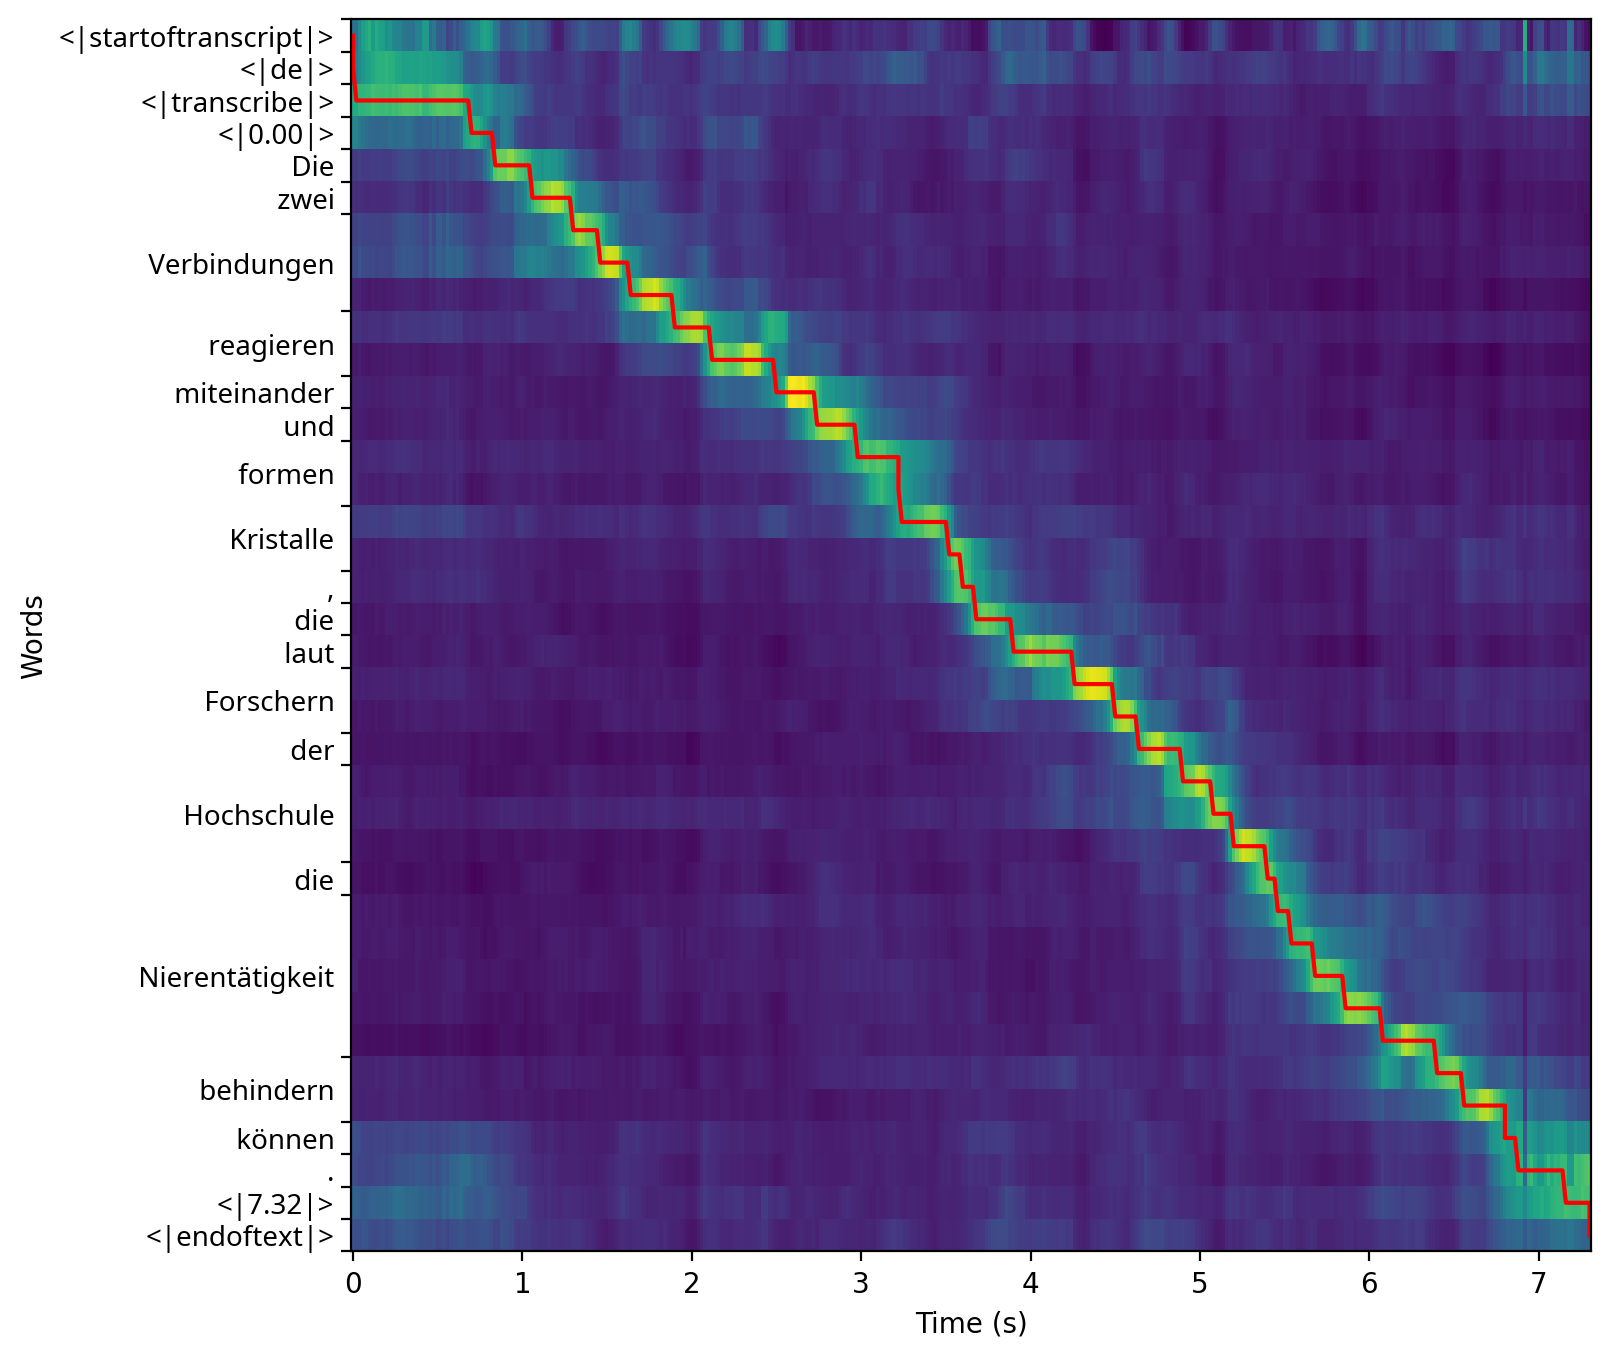

word  begin   end
0                Die   0.84  1.06
1               zwei   1.06  1.30
2       Verbindungen   1.30  1.90
3          reagieren   1.90  2.50
4        miteinander   2.50  2.74
5                und   2.74  2.98
6             formen   2.98  3.24
7          Kristalle   3.24  3.60
8                die   3.68  3.90
9               laut   3.90  4.26
10         Forschern   4.26  4.64
11               der   4.64  4.90
12        Hochschule   4.90  5.40
13               die   5.40  5.46
14   Nierentätigkeit   5.46  6.40
15         behindern   6.40  6.80
16            können   6.80  6.88

 Während der 1960er-Jahre arbeitete Brzezinski als Berater für John F. Kennedy sowie anschließend für die Regierung rund um Lyndon B. Johnson.


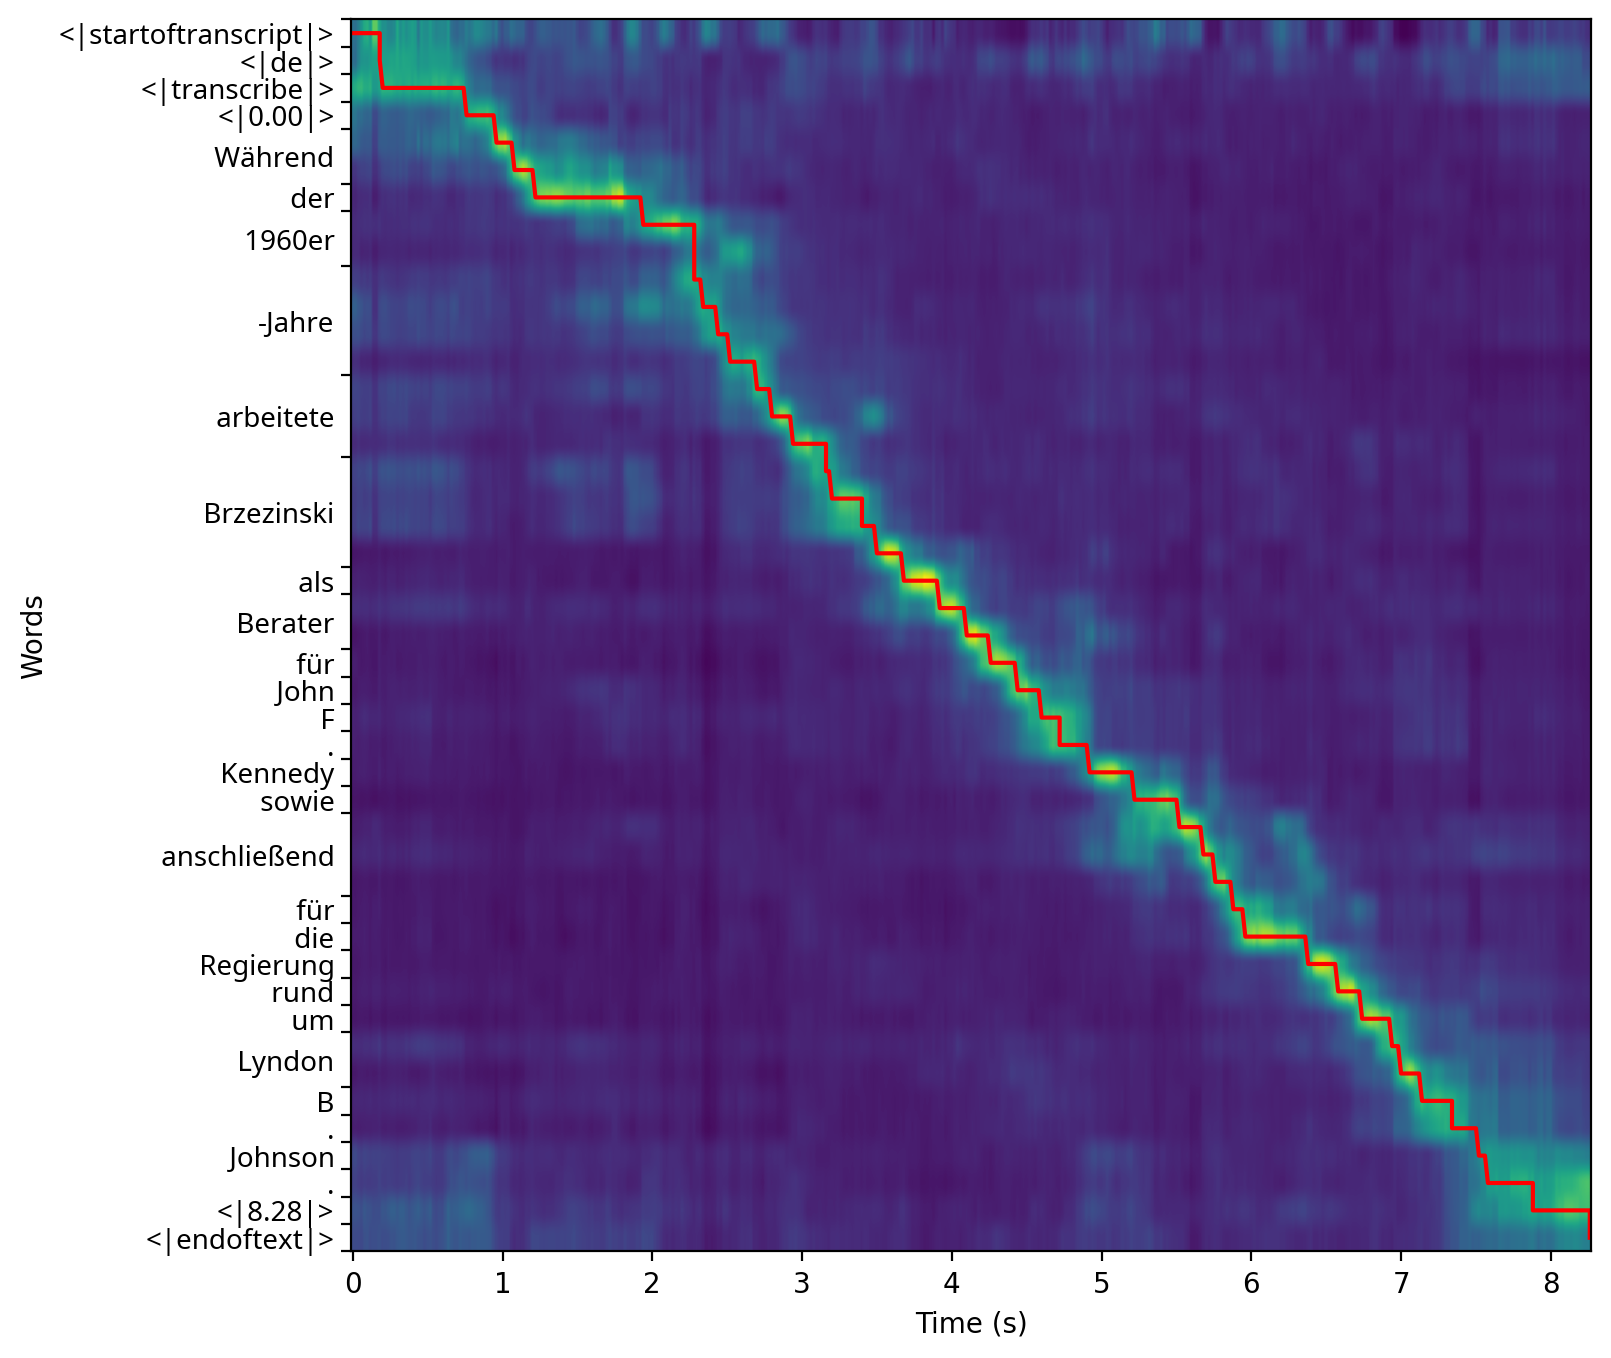

word  begin   end
0         Während   0.96  1.22
1             der   1.22  1.94
2          1960er   1.94  2.28
3          -Jahre   2.28  2.70
4       arbeitete   2.70  3.16
5      Brzezinski   3.16  3.68
6             als   3.68  3.92
7         Berater   3.92  4.26
8             für   4.26  4.44
9            John   4.44  4.60
10              F   4.60  4.72
11        Kennedy   4.92  5.22
12          sowie   5.22  5.52
13   anschließend   5.52  5.88
14            für   5.88  5.96
15            die   5.96  6.38
16      Regierung   6.38  6.58
17           rund   6.58  6.74
18             um   6.74  6.94
19         Lyndon   6.94  7.14
20              B   7.14  7.34
21        Johnson   7.52  7.58

 Grönland war schwerlich besiedelt. In den altnordischen Sagen heißt es, dass Erik der Rote wegen Mordes aus Island verbannt wurde. Als er weiter nach Westen reiste, fand er Grönland und gab ihm den Namen Grönland.


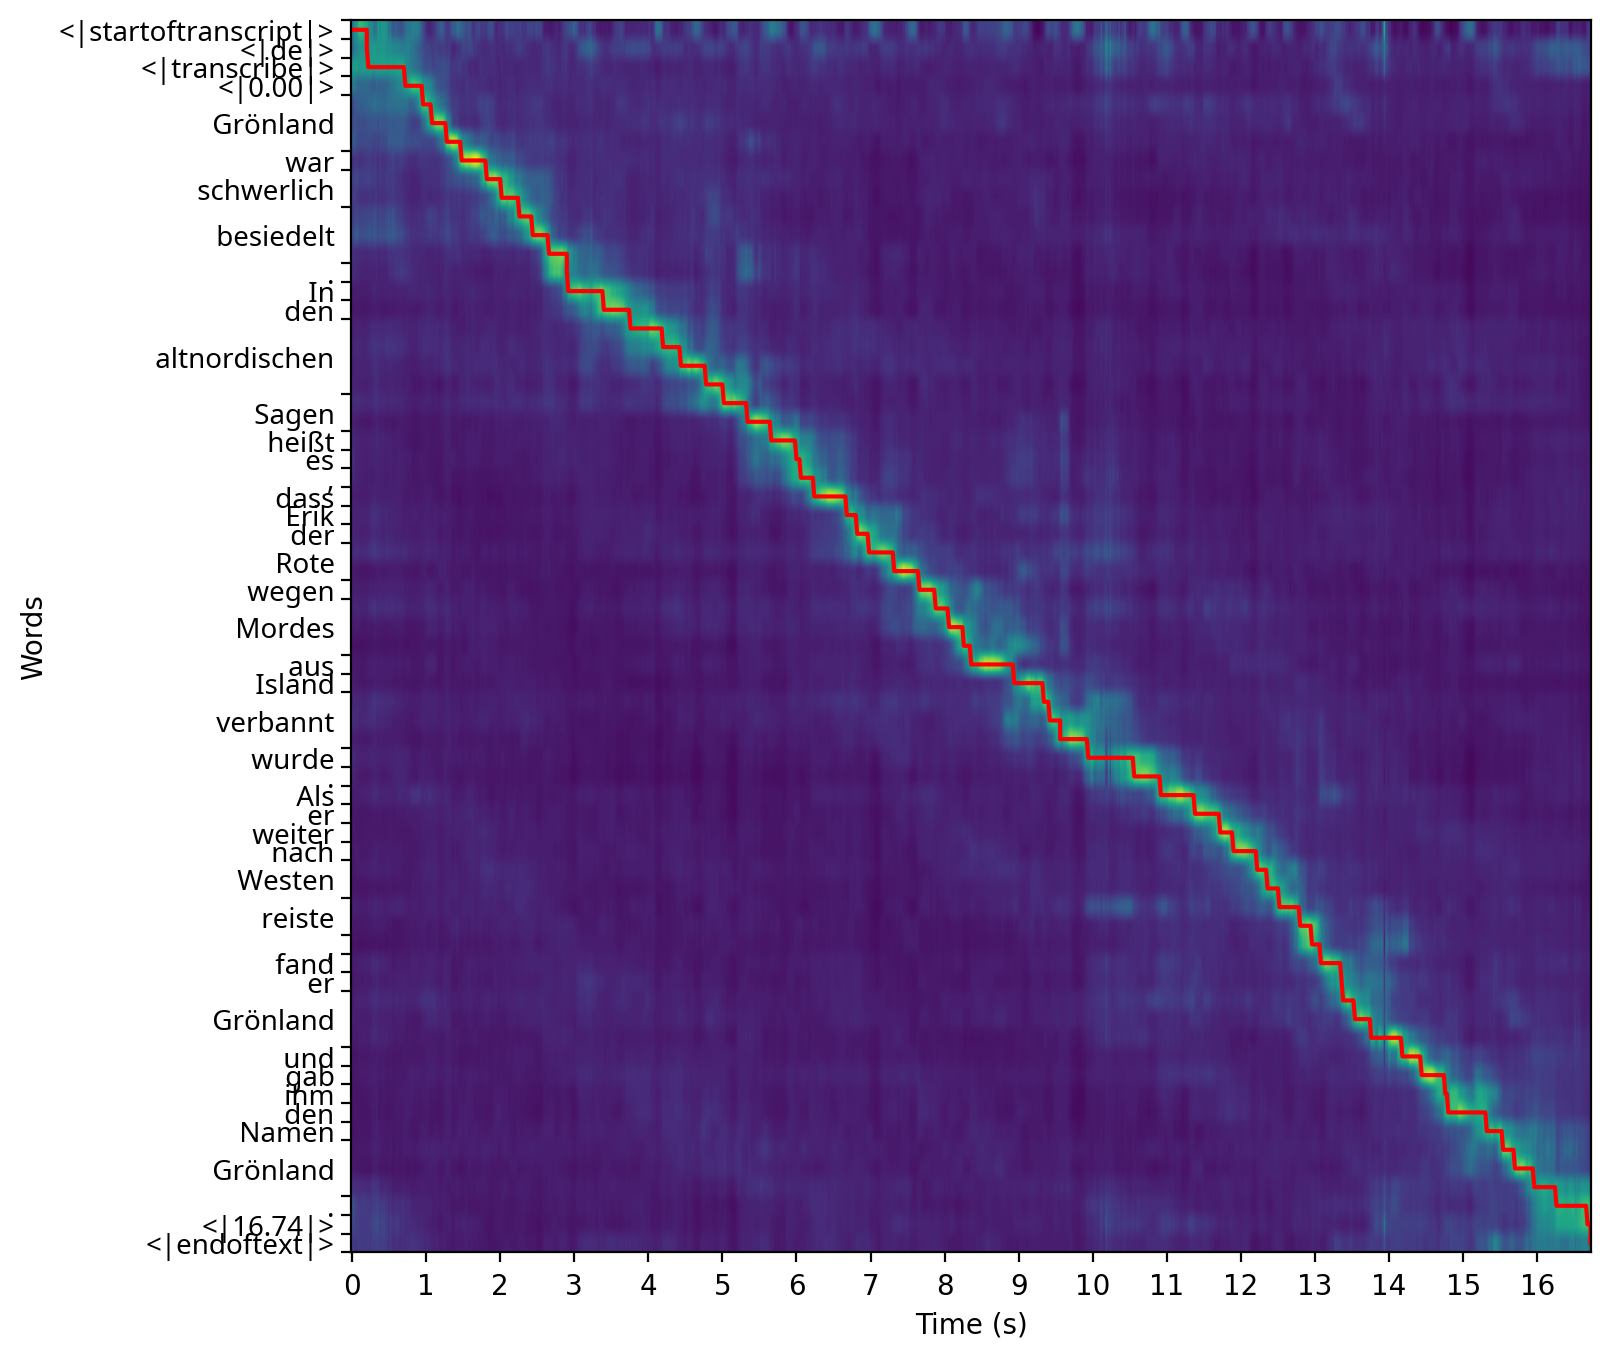

word  begin    end
0         Grönland   0.96   1.48
1              war   1.48   1.82
2       schwerlich   1.82   2.26
3        besiedelt   2.26   2.90
4               In   2.92   3.40
5              den   3.40   3.76
6    altnordischen   3.76   5.02
7            Sagen   5.02   5.66
8            heißt   5.66   6.00
9               es   6.00   6.06
10            dass   6.24   6.68
11            Erik   6.68   6.82
12             der   6.82   6.98
13            Rote   6.98   7.66
14           wegen   7.66   7.88
15          Mordes   7.88   8.36
16             aus   8.36   8.94
17          Island   8.94   9.34
18        verbannt   9.34   9.94
19           wurde   9.94  10.56
20             Als  10.92  11.38
21              er  11.38  11.72
22          weiter  11.72  11.90
23            nach  11.90  12.22
24          Westen  12.22  12.52
25          reiste  12.52  12.96
26            fand  13.08  13.36
27              er  13.36  13.38
28        Grönland  13.38  14.18
29             und  14.18  14.44
30             gab  14.44  14.76
31             ihm  14.76  14.80
32             den  14.80  15.32
33           Namen  15.32  15.54
34        Grönland  15.54  16.26

 Im Norden ist die Region von der Sahelzone begrenzt und im Süden und Westen vom Atlantischen Ozean.


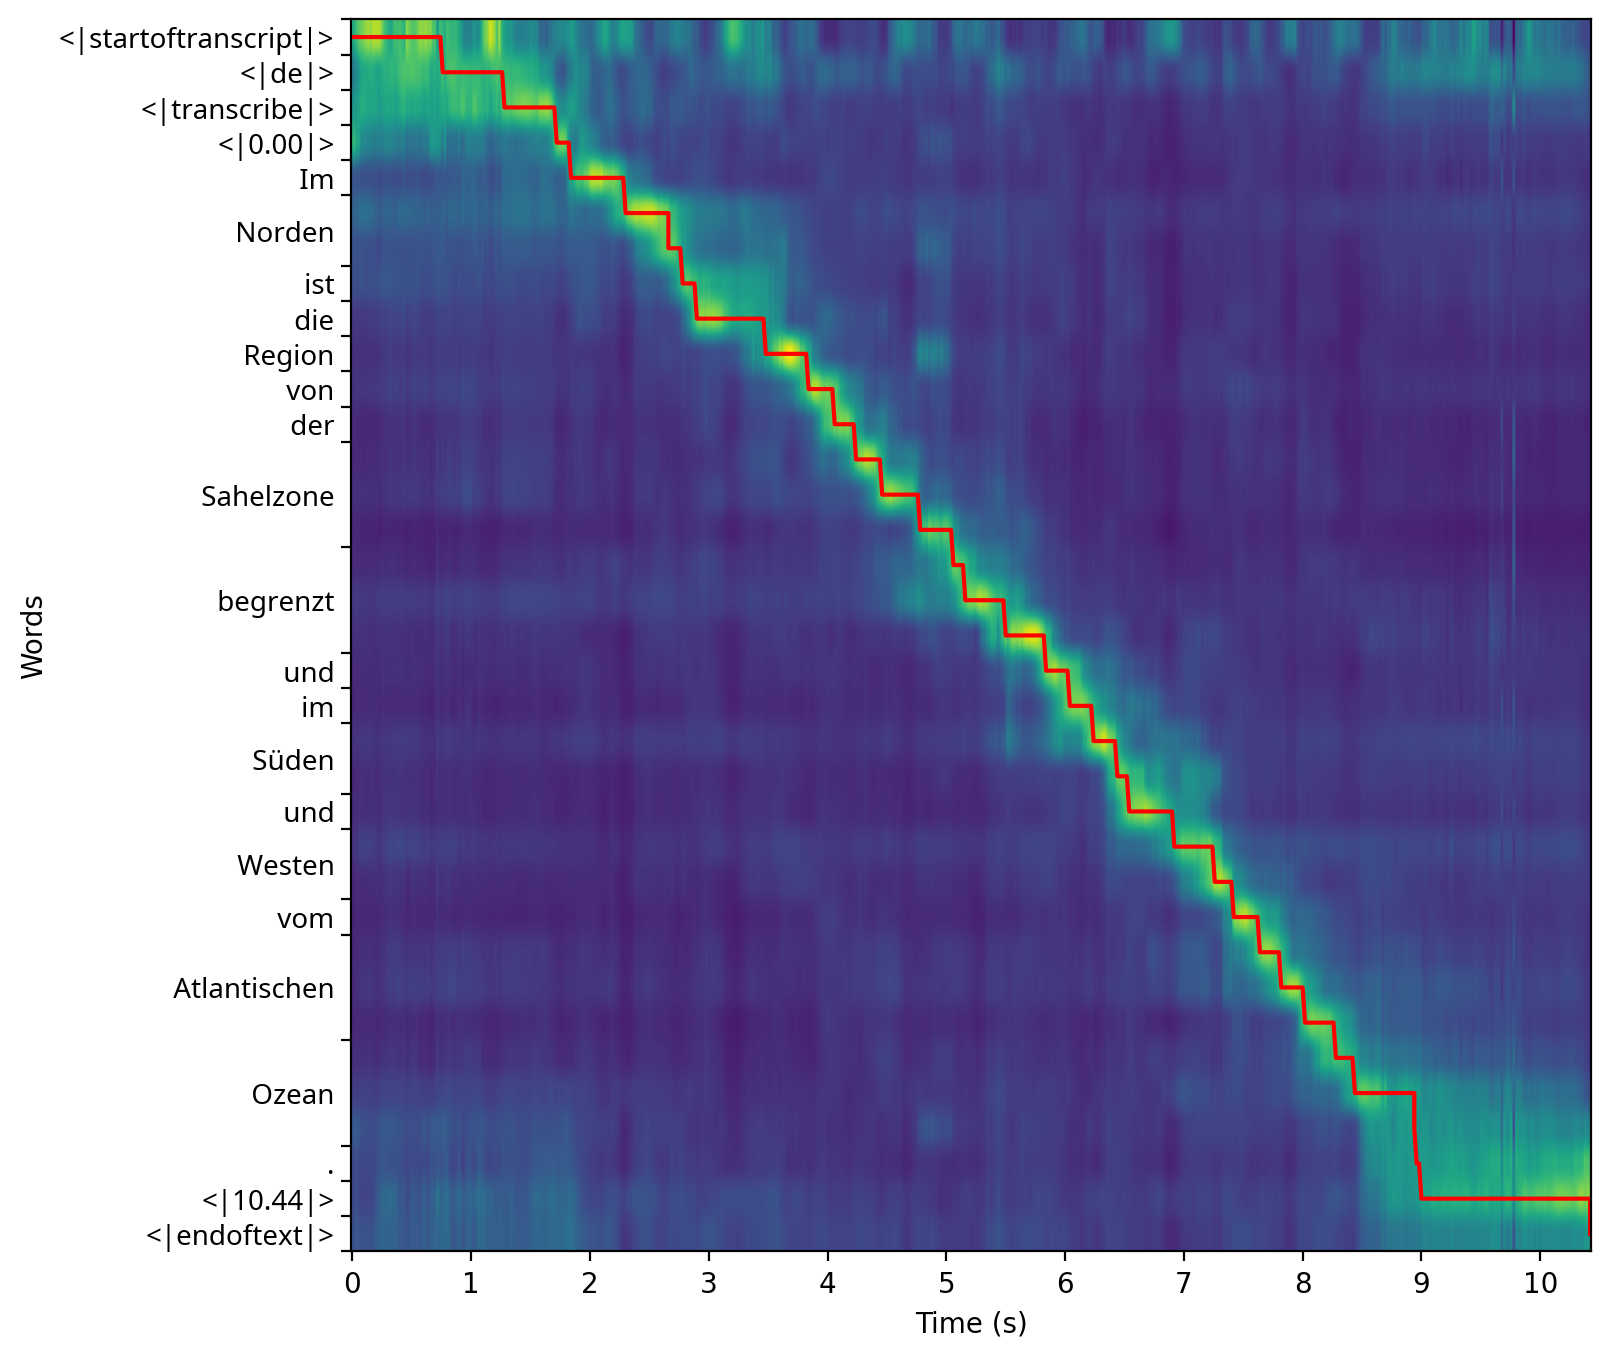

word  begin   end
0              Im   1.84  2.30
1          Norden   2.30  2.78
2             ist   2.78  2.90
3             die   2.90  3.48
4          Region   3.48  3.84
5             von   3.84  4.06
6             der   4.06  4.24
7       Sahelzone   4.24  5.06
8        begrenzt   5.06  5.84
9             und   5.84  6.04
10             im   6.04  6.24
11          Süden   6.24  6.54
12            und   6.54  6.92
13         Westen   6.92  7.42
14            vom   7.42  7.64
15   Atlantischen   7.64  8.28
16          Ozean   8.28  8.96

 Die Teilnehmerzahl war so groß, dass es nicht allen möglich war, Zugang zur Bestattung auf dem Petersplatz zu erhalten.


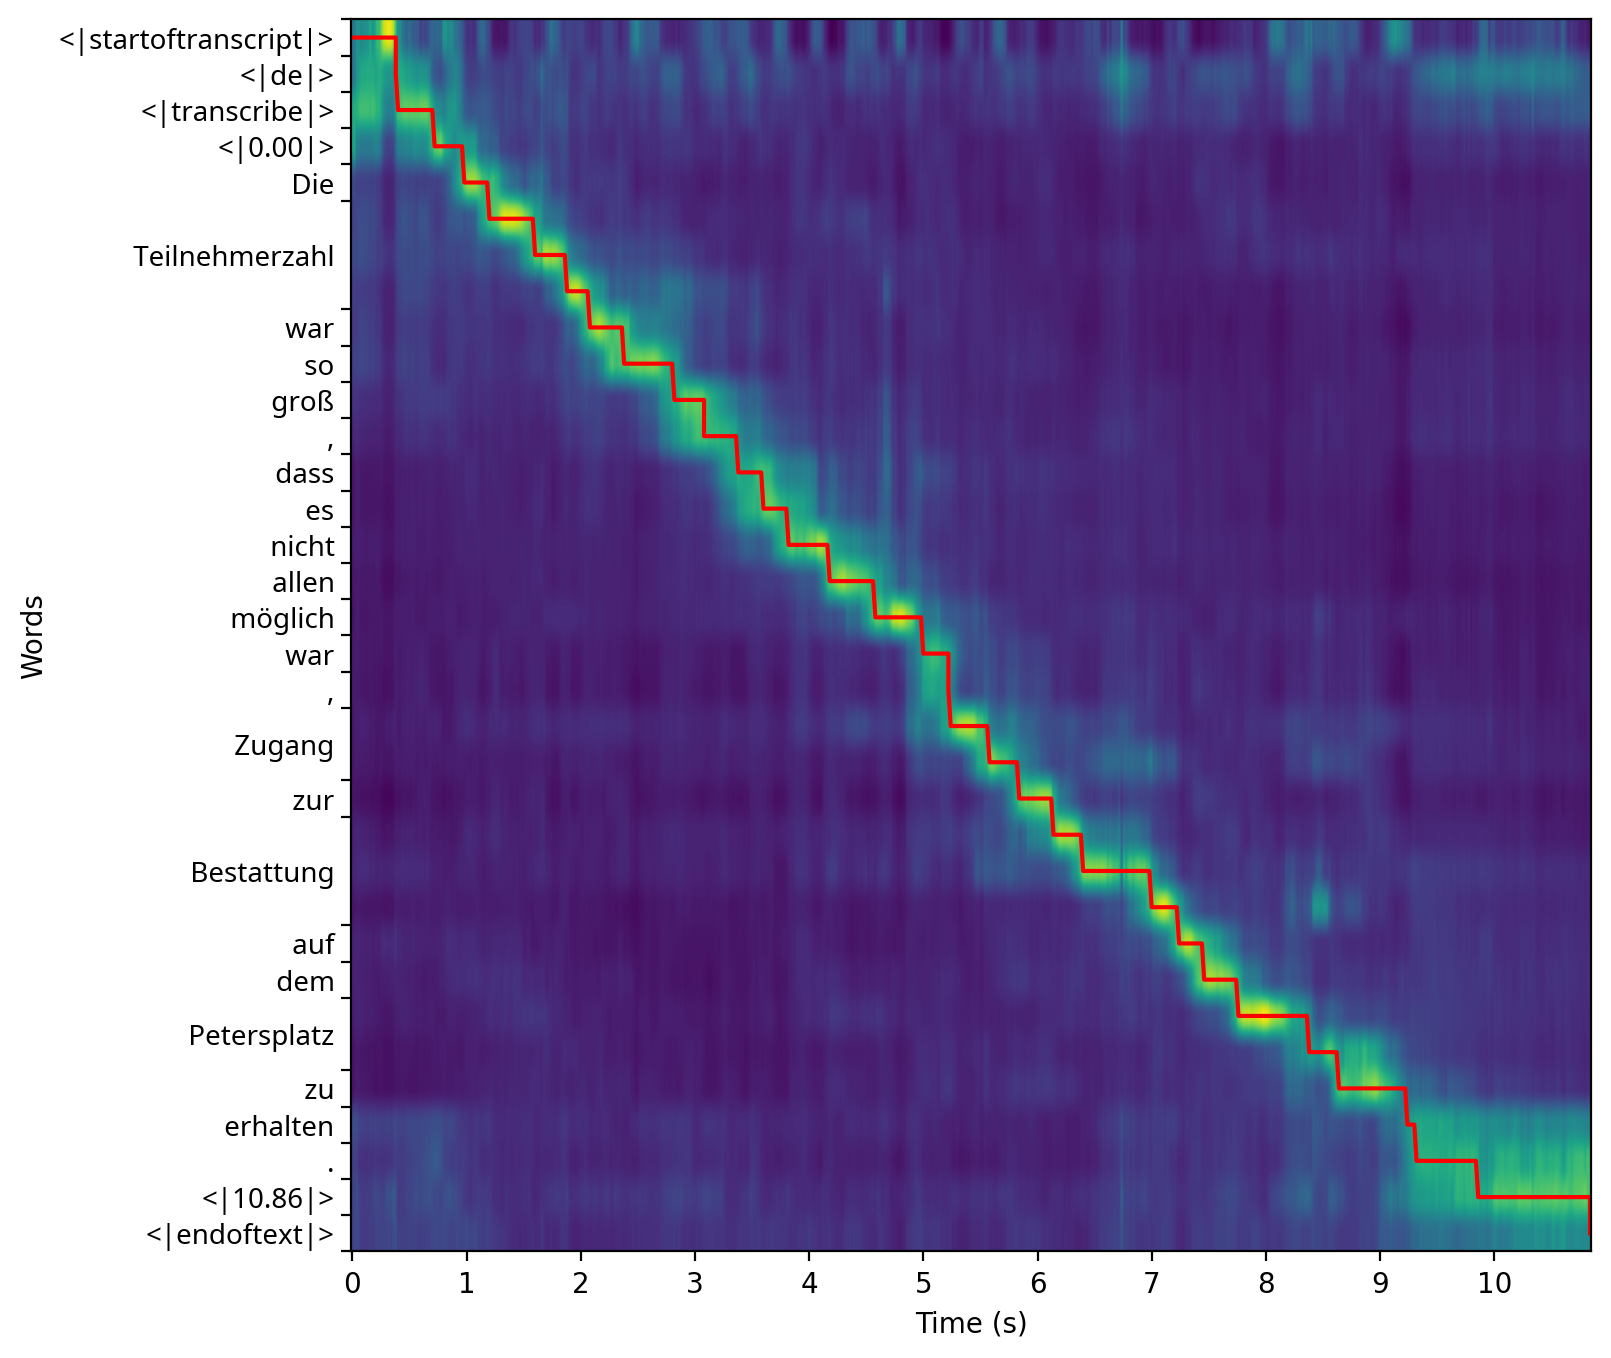

word  begin   end
0               Die   0.98  1.20
1    Teilnehmerzahl   1.20  2.08
2               war   2.08  2.38
3                so   2.38  2.82
4              groß   2.82  3.08
5              dass   3.38  3.60
6                es   3.60  3.82
7             nicht   3.82  4.18
8             allen   4.18  4.58
9           möglich   4.58  5.00
10              war   5.00  5.22
11           Zugang   5.24  5.84
12              zur   5.84  6.14
13       Bestattung   6.14  7.24
14              auf   7.24  7.46
15              dem   7.46  7.76
16      Petersplatz   7.76  8.64
17               zu   8.64  9.24
18         erhalten   9.24  9.32

In [ ]:
# for the first 10 examples in the dataset
for (audio, label), transcription in zip(dataset, transcriptions[:10]):
    print(transcription)

    duration = len(audio)
    # audio = audio.view(-1)
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio)).cuda()
    tokens = torch.tensor(
        [
            *tokenizer.sot_sequence,
            tokenizer.timestamp_begin,
        ] + tokenizer.encode(transcription) + [
            tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
            tokenizer.eot,
        ]
    ).cuda()
    with torch.no_grad():
        logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

    weights = torch.cat(QKs)  # layers * heads * tokens * frames
    weights = weights[:, :, :, : duration // AUDIO_SAMPLES_PER_TOKEN].cpu()
    weights = median_filter(weights, (1, 1, 1, medfilt_width))
    weights = torch.tensor(weights * qk_scale).softmax(dim=-1)

    w = weights / weights.norm(dim=-2, keepdim=True)
    matrix = w[-6:].mean(axis=(0, 1))

    alignment = dtw(-matrix.double().numpy())

    jumps = np.pad(np.diff(alignment.index1s), (1, 0), constant_values=1).astype(bool)
    jump_times = alignment.index2s[jumps] * AUDIO_TIME_PER_TOKEN
    words, word_tokens = split_tokens(tokens)

    '''
    Visualizing Alignment and Attention Weights
    This part visualizes the alignment between audio and text using the calculated attention weights.
    It plots the cross-attention matrix and overlays the DTW path, showing how each word aligns with segments of the audio.
    '''
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect="auto")
    plt.plot(alignment.index2s, alignment.index1s, color="red")

    xticks = np.arange(0, matrix.shape[1], 1 / AUDIO_TIME_PER_TOKEN)
    xticklabels = (xticks * AUDIO_TIME_PER_TOKEN).round().astype(np.int32)
    plt.xticks(xticks, xticklabels)
    plt.xlabel("Time (s)")

    # display tokens and words as tick labels
    ylims = plt.gca().get_ylim()

    ax = plt.gca()
    ax.tick_params('both', length=0, width=0, which='minor', pad=6)

    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.invert_yaxis()
    ax.set_ylim(ylims)

    major_ticks = [-0.5]
    minor_ticks = []
    current_y = 0

    for word, word_token in zip(words, word_tokens):
        minor_ticks.append(current_y + len(word_token) / 2 - 0.5)
        current_y += len(word_token)
        major_ticks.append(current_y - 0.5)

    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(words))
    ax.set_yticks(major_ticks)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    for label in ax.get_yminorticklabels():
        label.set_fontproperties(prop)

    plt.ylabel("Words")
    plt.show()

    '''
    Generating Word-Level Timestamps
    Finally, the code calculates and displays the start and end times for each word in the transcription.
    This allows for a granular analysis of the speech, which can be used for detailed subtitles, speech analysis, and more interactive applications.
    '''
    word_boundaries = np.pad(np.cumsum([len(t) for t in word_tokens[:-1]]), (1, 0))
    begin_times = jump_times[word_boundaries[:-1]]
    end_times = jump_times[word_boundaries[1:]]

    data = [
        dict(word=word, begin=begin, end=end)
        for word, begin, end in zip(words[:-1], begin_times, end_times)
        if not word.startswith("<|") and word.strip() not in ".,!?、。"
    ]

    display(pd.DataFrame(data))
    display(HTML("<hr>"))

# Gratitude

Many thanks to Naval Katoch for his valuable technical insights.